In [1]:
version = 'v20250521'

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold,cross_val_predict
from skmap.misc import find_files, GoogleSheet, ttprint
import joblib
import numpy as np

# # discretinized points
# df = pd.read_parquet('./material/agg_pixel_change.pq')
# geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
# df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:3035")
# print(df.shape)

# # samples # in the end, we didn't opt for sample vs. pixel comparison
# spl = pd.read_parquet(f'./material/srs_agg_{version}.pq')
# geometry = [Point(xy) for xy in zip(spl['lon_mean'], spl['lat_mean'])]
# spl = gpd.GeoDataFrame(spl, geometry=geometry, crs="EPSG:4032")
# spl = spl.to_crs('EPSG:3035')


## read in the predicted point level data

In [2]:
agg = []
for isize in [2.5, 10, 40, 200]:
    tgg = gpd.read_file(f'./material/grid_all.{isize}km_agg.srs.{version}.gpkg')
    tgg['size'] = isize
    agg.append(tgg)
    
df = pd.concat(agg)

## plot

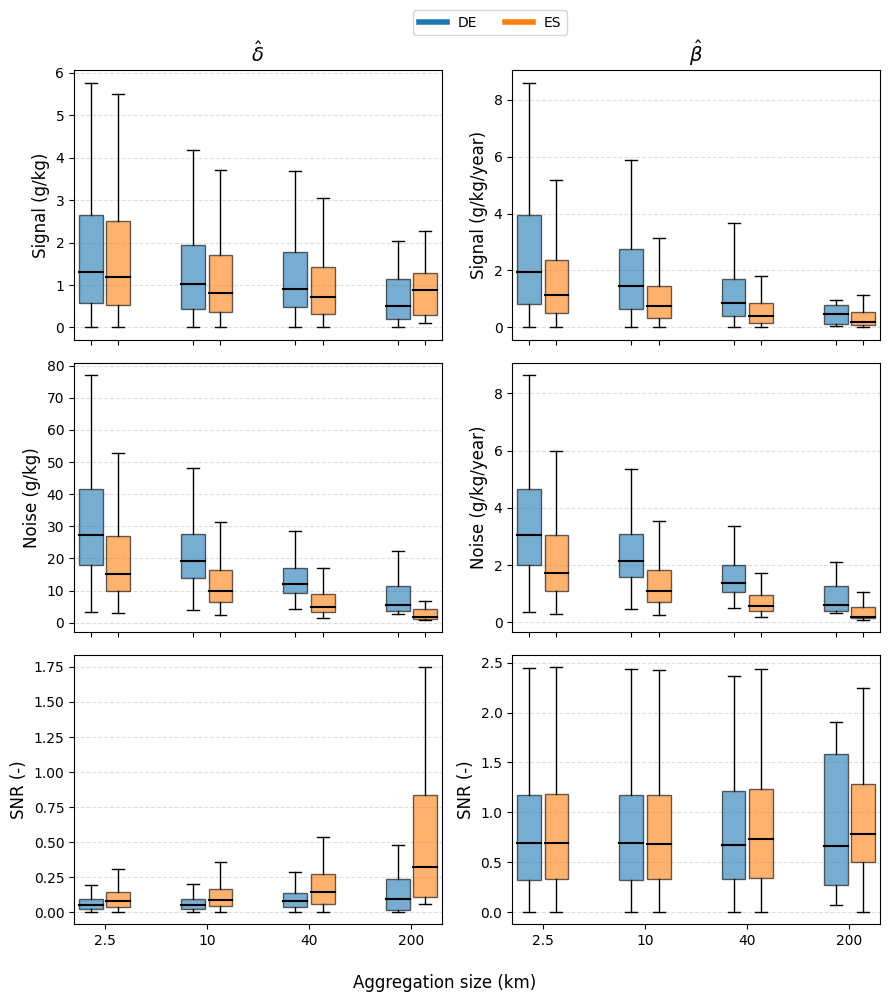

In [39]:
import matplotlib.pyplot as plt
import numpy as np

row_defs = [
    ('signal_change', 'signal_series', 'Signal'),
    ('noise_change',  'noise_series',  'Noise'),
    ('snr_change',    'snr_series',    'SNR'),
]

sizes_to_plot = [2.5, 10, 40, 200]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 10), sharey=False)

for r, (col_change, col_trend, col_name) in enumerate(row_defs):
    for c, which_col in enumerate([col_change, col_trend]):
        ax = axes[r, c]

        data_for_boxes = []
        positions = []
        base_positions = np.arange(len(sizes_to_plot)) * 3.0
        offset = [-0.4, 0.4]  # DE left, ES right

        for i, sz in enumerate(sizes_to_plot):
            for j, cntr in enumerate(['DE', 'ES']):
                vals = df.loc[
                    (df['size'] == sz) &
                    (df['CNTR_CODE'] == cntr),
                    which_col
                ].dropna()
                data_for_boxes.append(vals)
                positions.append(base_positions[i] + offset[j])

        bp = ax.boxplot(
            data_for_boxes,
            patch_artist=True,
            widths=0.7,
            positions=positions,
            showfliers=False
        )

        # color boxes
        colors = ['tab:blue', 'tab:orange']
        for k, patch in enumerate(bp['boxes']):
            patch.set_facecolor(colors[k % 2])
            patch.set_alpha(0.6)
            patch.set_edgecolor('black')

        # median lines black
        for median in bp['medians']:
            median.set_color('black')
            median.set_linewidth(1.5)

        # hide x labels for all except bottom row
        if r < 2:
            ax.set_xticklabels([])
        else:
            ax.set_xticks(base_positions)
            ax.set_xticklabels([str(sz) for sz in sizes_to_plot])

        # add only one central xlabel across both bottom plots
        ax.set_xlabel("")
            
        if 'snr' in which_col:
            ax.set_ylabel(f'{col_name} (-)', fontsize=12)
        elif 'change' in which_col:
            ax.set_ylabel(f'{col_name} (g/kg)', fontsize=12)
        else:
            ax.set_ylabel(f'{col_name} (g/kg/year)', fontsize=12)
            
        ax.grid(axis='y', linestyle='--', alpha=0.4)

# column headers
axes[0, 0].set_title(r"$\hat{\delta}$", fontsize=14)
axes[0, 1].set_title(r"$\hat{\beta}$", fontsize=14)

# legend on top
handles = [
    plt.Line2D([0], [0], color='tab:blue', lw=4, label='DE'),
    plt.Line2D([0], [0], color='tab:orange', lw=4, label='ES')
]
fig.legend(
    handles=handles,
    loc='upper center',
    ncol=2,
    frameon=True,
    bbox_to_anchor=(0.55, 1.0)
)

fig.text(
    0.5,                # x position (center of figure)
    0.02,               # y position (a bit below the plots)
    "Aggregation size (km)",
    ha='center',
    va='center',
    fontsize=12
)

plt.tight_layout(rect=[0, 0.04, 1, 0.98])
plt.savefig(f'./figure/plot_agg_compare.pdf', bbox_inches='tight')
plt.show()

